# Sensorless Drive Diagnosis

> In this example, the main focus is the classification of individual states of a motor.

In [ ]:
# |hide
from nbdev.showdoc import *

In [ ]:
# | hide
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import pandas as pd
import copy

from sklearn.metrics import classification_report
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from matplotlib import pyplot as plt
import seaborn as sns

from mlmvn.layers import FirstLayer, HiddenLayer, OutputLayer, cmplx_phase_activation
from mlmvn.loss import ComplexMSELoss, ComplexMSE_adjusted_error
from mlmvn.optim import MySGD, ECL
from pathlib import Path
from clearml import Task, Logger

In [ ]:
# | hide
# --- helper functions ---
def reverse_one_hot(x, neuronCats):
    a = np.zeros(len(x))
    x = torch.detach(x)
    for i in range(len(x)):
        a[i] = torch.max(x[i]) - 1 + np.argmax(x[i]) * neuronCats
    return a


def accuracy(out, yb):
    out = out.type(torch.double)
    yb = yb.type(torch.double)
    x = 0
    for i in range(len(out)):
        x += torch.equal(out[i], yb[i])
    return x / len(out)


def prepare_data(x_train, x_valid, y_train, y_valid, neuronCats):
    # one-hot encoding
    numSamples, numFeatures = x_valid.shape
    y_valid_int = y_valid
    y2 = y_valid + 1  # auxiliary variable so that classes start at 1 and not 0
    numClasses = max(y2)
    target_ids = range(numClasses)
    no = int(np.ceil(numClasses / neuronCats))  # number of output neurons
    if no != 1:
        y_valid = torch.zeros(numSamples, no)
        for i in range(numSamples):
            k = int(np.ceil(y2[i] / neuronCats)) - 1
            c = np.mod((y2[i] - 1), neuronCats) + 1
            y_valid[i, k] = c
    numSamples, numFeatures = x_train.shape
    y_train_int = y_train
    y2 = y_train + 1  # auxiliary variable so that classes start at 1 and not 0
    if no != 1:
        y_train = torch.zeros(numSamples, no)
        for i in range(numSamples):
            k = int(np.ceil(y2[i] / neuronCats)) - 1
            c = np.mod((y2[i] - 1), neuronCats) + 1
            y_train[i, k] = c
    del y2

    # Convert numpy arrays into torch tensors
    x_train, y_train, x_valid, y_valid = map(
        torch.tensor, (x_train, y_train, x_valid, y_valid)
    )
    if y_train.size().__len__() == 1:
        y_train = torch.unsqueeze(y_train, 1)
        y_valid = torch.unsqueeze(y_valid, 1)

    # convert angles to complex numbers on unit-circle
    x_train = torch.exp(1.0j * x_train)
    x_valid = torch.exp(1.0j * x_valid)

    return x_train, x_valid, y_train, y_valid


def get_splitted_data(X, y, neuronCats):
    x_train, x_valid, y_train, y_valid = train_test_split(
        X, y, train_size=46806, random_state=42
    )
    x_train, x_valid, y_train, y_valid = prepare_data(
        x_train, x_valid, y_train, y_valid, neuronCats
    )

    return x_train, x_valid, y_train, y_valid


def get_splitted_data_by_index(X, y, neuronCats, train_index, test_index):
    x_train, x_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    x_train, x_valid, y_train, y_valid = prepare_data(
        x_train, x_valid, y_train, y_valid, neuronCats
    )
    return x_train, x_valid, y_train, y_valid


# --- Plots ---
def plot_loss(title, losses, scores):
    plt.rcParams["axes.grid"] = True
    fig, (ax1) = plt.subplots(1, 1, figsize=(8, 4))
    fig.suptitle("CVNN - Moons")
    ax1.plot(np.linspace(1, len(losses), len(losses)), losses)
    ax1.set_xlabel("Epoch")
    ax1.set_xlim(0, len(losses))

    ax1.plot(np.linspace(1, len(scores), len(scores)), scores)
    ax1.set_xlabel("Epoch")
    ax1.set_xlim(0, len(losses))

    ax1.legend(["Acc", "Loss"])

    plt.show()


def plot_weights(title, ylabel_1, ylabel_2, weights_real, weights_imag):
    # y_min = np.min([np.min(weights_real), np.min(weights_imag)])
    # y_max = np.max([np.max(weights_real), np.max(weights_imag)])

    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 3))
    fig.suptitle(title)
    ax[0].plot(np.linspace(1, len(weights_real), len(weights_real)), weights_real)
    ax[0].set_xlabel("Step")
    ax[0].set_ylabel(ylabel_1)
    # ax[0].set_title("Real Valued Weigts")
    ax[0].set_xlim(0, len(weights_real))
    # ax[0].set_ylim(y_min, y_max)

    ax[1].plot(np.linspace(1, len(weights_imag), len(weights_imag)), weights_imag)
    ax[1].set_xlabel("Step")
    ax[1].set_ylabel(ylabel_2)
    # ax[1].set_title("Imaginary Valued Weights")
    ax[1].set_xlim(0, len(weights_imag))
    # ax[1].set_ylim(y_min, y_max)

    plt.show()


def plot_loss_acc_list(title, list_losses, list_scores, image_name):
    losses = np.mean(list_losses, axis=0)
    scores = np.mean(list_scores, axis=0)

    losses_std = np.std(list_losses, axis=0)
    scores_std = np.std(list_scores, axis=0)

    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 3))
    fig.suptitle(title)
    ax1.plot(np.linspace(1, len(losses), len(losses)), losses)
    ax1.fill_between(
        np.linspace(1, len(losses), len(losses)),
        losses + losses_std,
        losses - losses_std,
        alpha=0.5,
        linewidth=0,
    )

    ax1.plot(np.linspace(1, len(scores), len(scores)), scores)
    ax1.fill_between(
        np.linspace(1, len(scores), len(scores)),
        scores + scores_std,
        scores - scores_std,
        alpha=0.5,
        linewidth=0,
    )
    ax1.set_xlabel("Epoch")
    plt.grid(visible=True)
    plt.legend(["Loss Mean", "Loss Std", "Acc. Mean", "Acc. Std"])
    fig.savefig(image_name, format="png", dpi=600)

    plt.show()
    # save
    # fig.savefig(image_name + ".svg", format="svg", dpi=600)


# --- Logging ---
model_dict: dict = {}


def fc_hook(layer_name, module, grad_input, grad_output):
    if layer_name in model_dict:
        model_dict[layer_name]["weights"] = module.weights.detach().clone()
        model_dict[layer_name]["bias"] = module.bias.detach().clone()
        model_dict[layer_name]["grad_input"] = grad_input
        model_dict[layer_name]["grad_output"] = grad_output
    else:
        model_dict[layer_name] = {}
        model_dict[layer_name]["weights"] = module.weights.detach().clone()
        model_dict[layer_name]["bias"] = module.bias.detach().clone()
        model_dict[layer_name]["grad_input"] = grad_input
        model_dict[layer_name]["grad_output"] = grad_output

In [ ]:
# | hide
# control variables
# number of categories a neuron can distinguish / parameter that determines the number of output neurons
neuronCats = 1
# number of categories per neuron, i.e. neuronCats (+ 1 for others in case of multiple Outputs)
categories = 2
# how often a classification sector occurs (1 means no periodicity)
periodicity = 1
# path to store best model parameters

## Load Data

In [ ]:
train_csv = pd.read_csv(
    "data/autass_data2.csv",
    header=None,
    dtype=np.double,
)
data = np.array(train_csv.values[:, 1:50])
del train_csv

In [ ]:
X = data[:, 0:48]
y = data[:, 48].astype(int) - 1

yt = copy.copy(y)
yt[yt == 0] = 20
yt[yt == 1] = 21
yt[yt == 2] = 22
yt[yt == 3] = 23
yt[yt == 4] = 26
yt[yt == 5] = 24
yt[yt == 6] = 27
yt[yt == 7] = 29
yt[yt == 8] = 30
yt[yt == 9] = 25
yt[yt == 10] = 28
yt -= 20
y = yt
del yt

## Config

In [ ]:
epochs = 200
batch_size = 538
lr = 1
clip_angle_value = 1000000

## Single Layer

### MLMVN [48-10-11]

In [ ]:
PATH = str(Path.cwd() / "models/autass-mlmvn_48-10-11.pt")

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 10)
        self.phase_act1 = cmplx_phase_activation()
        self.linear_out = OutputLayer(10, 11)
        self.phase_act2 = cmplx_phase_activation()
        # Hooks
        self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
            self.first_layer_backward_hook
        )
        self.output_hook_handle = self.linear_out.register_full_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.linear_out(x)
        x = self.phase_act2(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)
    return losses, scores

In [ ]:
task = Task.init(
    project_name="mlmvn",
    task_name="SDD-mlmvn-[48-10-11]",
    tags=["mlmvn", "SDD", "multiple_runs", "adjusted_loss_clip_angle_value"],
)
writer = SummaryWriter()

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": 1,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
    "layer": "[48-10-11]",
    "loss": "ComplexMSE_adjusted_error",
    "clip_angle_value": clip_angle_value,
}
task.connect(config_dict)

ClearML Task: created new task id=aed2c1e548d44d02876e693409da4ac3
ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/aed2c1e548d44d02876e693409da4ac3/output/log


{'learning_rate': 1,
 'epochs': 200,
 'batch_size': 538,
 'optim': 'ECL',
 'categories': 2,
 'periodicity': 1,
 'layer': '[48-10-11]',
 'loss': 'ComplexMSE_adjusted_error',
 'clip_angle_value': 1000000}

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_losses = []
list_scores = []
list_acc = []
list_loss = []
list_f1 = []
list_precision = []
list_recall = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )

    model = Model(categories=categories, periodicity=periodicity)
    criterion = ComplexMSE_adjusted_error.apply
    optimizer = ECL(model.parameters(), lr=lr)

    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    list_scores.append(scores)
    list_losses.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    list_acc.append(acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))
    list_f1.append(
        f1_score(y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0)
    )
    list_precision.append(
        precision_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )
    list_recall.append(
        recall_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )

Logger.current_logger().report_single_value(
    name="val_accuracy_mean",
    value=np.mean(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_accuracy_std",
    value=np.std(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_f1_mean",
    value=np.mean(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_f1_std",
    value=np.std(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_precision_mean",
    value=np.mean(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_precision_std",
    value=np.std(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_recall_mean",
    value=np.mean(list_recall),
)
Logger.current_logger().report_single_value(
    name="val_recall_std",
    value=np.std(list_recall),
)

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



2022-09-27 22:37:31,629 - clearml.frameworks - INFO - Found existing registered model id=caa96da5a415490ca1ea0f95b383f403 [/home/antonpfeifer/Documents/mlmvn/nbs/examples/autass/models/autass-mlmvn_48-10-11.pt] reusing it.
Epoch 9 loss is 0.24486756715526192
Epoch 19 loss is 0.16472245788019146
Epoch 29 loss is 0.16197286684855702
Epoch 39 loss is 0.15777335760350167
Epoch 49 loss is 0.16362277181734114
Epoch 59 loss is 0.1599623075779962
Epoch 69 loss is 0.15505627729450555
Epoch 79 loss is 0.1516815979779308
Epoch 89 loss is 0.14756507300426192
Epoch 99 loss is 0.14990614337584326
Epoch 109 loss is 0.14464806634677907
Epoch 119 loss is 0.14414441882839768
Epoch 129 loss is 0.133414154667594
Epoch 139 loss is 0.1568121289545272
Epoch 149 loss is 0.13148384624669937
Epoch 159 loss is 0.15520714324892884
Epoch 169 loss is 0.15488150667967812
Epoch 179 loss is 0.16196303491616978
Epoch 189 loss is 0.17048013425110728
Epoch 199 loss is 0.253481823204663
Train Acc.:  0.9061037878949729
   

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.23206087884330276
Epoch 19 loss is 0.223541648173787
Epoch 29 loss is 0.19793911944454762
Epoch 39 loss is 0.20525953919872755
Epoch 49 loss is 0.19172214725700548
Epoch 59 loss is 0.180403134615211
Epoch 69 loss is 0.20454411746859222
Epoch 79 loss is 0.22207294107387418
Epoch 89 loss is 0.1823581614612617
Epoch 99 loss is 0.1984208152000532
Epoch 109 loss is 0.21770198580729927
Epoch 119 loss is 0.26321624687915784
Epoch 129 loss is 0.2366645070320064
Epoch 139 loss is 0.26308797516611215
Epoch 149 loss is 0.2796785803565688
Epoch 159 loss is 0.19642007623052968
Epoch 169 loss is 0.3310147275301174
Epoch 179 loss is 0.2874490546335206
Epoch 189 loss is 0.2595535203540301
Epoch 199 loss is 0.3217917178123802
Train Acc.:  0.8804452325506869
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1063
           1       0.89      0.87      0.88      1064
           2       0.98      0.96      0.97      1064
           3  

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.23712313444477043
Epoch 19 loss is 0.21309815317807554
Epoch 29 loss is 0.2151226041409042
Epoch 39 loss is 0.22794682641424854
Epoch 49 loss is 0.18590490342052546
Epoch 59 loss is 0.17194472537314034
Epoch 69 loss is 0.18656052422193878
Epoch 79 loss is 0.1756717054349332
Epoch 89 loss is 0.19215676606052032
Epoch 99 loss is 0.19421889588535315
Epoch 109 loss is 0.23849424654511947
Epoch 119 loss is 0.21172349809503013
Epoch 129 loss is 0.310951138936457
Epoch 139 loss is 0.40137440459088775
Epoch 149 loss is 0.3257708635272683
Epoch 159 loss is 0.3058673858224232
Epoch 169 loss is 0.3393692446068119
Epoch 179 loss is 0.3696819123265627
Epoch 189 loss is 0.3599098499384412
Epoch 199 loss is 0.4304120007418079
Train Acc.:  0.8721558741213921
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1064
           1       0.84      0.81      0.82      1064
           2       0.96      0.91      0.93      1064
           3

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.22525142483966729
Epoch 19 loss is 0.21769357020501426
Epoch 29 loss is 0.2577133298481112
Epoch 39 loss is 0.22213481954372305
Epoch 49 loss is 0.23841117493258804
Epoch 59 loss is 0.309014874649911
Epoch 69 loss is 0.35371038376681546
Epoch 79 loss is 0.3699092508438563
Epoch 89 loss is 0.36114378942190123
Epoch 99 loss is 0.3760639842052328
Epoch 109 loss is 0.289880557557834
Epoch 119 loss is 0.3542478901455959
Epoch 129 loss is 0.2415444508855365
Epoch 139 loss is 0.25469037973175684
Epoch 149 loss is 0.23138965174619833
Epoch 159 loss is 0.21245593786661174
Epoch 169 loss is 0.28983951582336215
Epoch 179 loss is 0.2624560468178941
Epoch 189 loss is 0.22517652315304382
Epoch 199 loss is 0.30955816883738974
Train Acc.:  0.830303159783793
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1063
           1       0.89      0.81      0.85      1064
           2       0.95      0.85      0.90      1064
           3 

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.2563851438763014
Epoch 19 loss is 0.21581594458135714
Epoch 29 loss is 0.2354525347648366
Epoch 39 loss is 0.19813069646116785
Epoch 49 loss is 0.23640784807386372
Epoch 59 loss is 0.2855586216205039
Epoch 69 loss is 0.31419042978716966
Epoch 79 loss is 0.3396274724821675
Epoch 89 loss is 0.3805541273460192
Epoch 99 loss is 0.2594859077291225
Epoch 109 loss is 0.27091326668934435
Epoch 119 loss is 0.26640856164548926
Epoch 129 loss is 0.2599984885766787
Epoch 139 loss is 0.24273455139343672
Epoch 149 loss is 0.3339575152030492
Epoch 159 loss is 0.2597825247475023
Epoch 169 loss is 0.2548200790331675
Epoch 179 loss is 0.2912208067110613
Epoch 189 loss is 0.29534861061989254
Epoch 199 loss is 0.35203137025199627
Train Acc.:  0.8437840493943214
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1064
           1       0.88      0.80      0.84      1064
           2       0.92      0.85      0.88      1064
           3 

In [ ]:
task.mark_completed()
task.close()

### MLMVN [48-20-11]

In [ ]:
PATH = str(Path.cwd() / "models/autass-mlmvn_48-20-11.pt")

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 20)
        self.phase_act1 = cmplx_phase_activation()
        self.linear_out = OutputLayer(20, 11)
        self.phase_act2 = cmplx_phase_activation()
        # Hooks
        self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
            self.first_layer_backward_hook
        )
        self.output_hook_handle = self.linear_out.register_full_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.linear_out(x)
        x = self.phase_act2(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)
    return losses, scores

In [ ]:
task = Task.init(
    project_name="mlmvn",
    task_name="SDD-mlmvn-[48-20-11]",
    tags=["mlmvn", "SDD", "multiple_runs", "adjusted_loss_clip_angle_value"],
)
writer = SummaryWriter()

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": 1,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
    "layer": "[48-20-11]",
    "loss": "ComplexMSE_adjusted_error",
    "clip_angle_value": clip_angle_value,
}
task.connect(config_dict)

ClearML Task: created new task id=7e81250b8f8a4d31b43661579158b428
ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/7e81250b8f8a4d31b43661579158b428/output/log


{'learning_rate': 1,
 'epochs': 200,
 'batch_size': 538,
 'optim': 'ECL',
 'categories': 2,
 'periodicity': 1,
 'layer': '[48-20-11]',
 'loss': 'ComplexMSE_adjusted_error',
 'clip_angle_value': 1000000}

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_losses = []
list_scores = []
list_acc = []
list_loss = []
list_f1 = []
list_precision = []
list_recall = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )

    model = Model(categories=categories, periodicity=periodicity)
    criterion = ComplexMSE_adjusted_error.apply
    optimizer = ECL(model.parameters(), lr=lr)

    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    list_scores.append(scores)
    list_losses.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    list_acc.append(acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))
    list_f1.append(
        f1_score(y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0)
    )
    list_precision.append(
        precision_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )
    list_recall.append(
        recall_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )

Logger.current_logger().report_single_value(
    name="val_accuracy_mean",
    value=np.mean(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_accuracy_std",
    value=np.std(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_f1_mean",
    value=np.mean(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_f1_std",
    value=np.std(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_precision_mean",
    value=np.mean(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_precision_std",
    value=np.std(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_recall_mean",
    value=np.mean(list_recall),
)
Logger.current_logger().report_single_value(
    name="val_recall_std",
    value=np.std(list_recall),
)

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



2022-09-27 22:55:28,643 - clearml.frameworks - INFO - Found existing registered model id=c337b94a22444d809d449783726d8ee2 [/home/antonpfeifer/Documents/mlmvn/nbs/examples/autass/models/autass-mlmvn_48-20-11.pt] reusing it.
Epoch 9 loss is 0.2058236759317573
Epoch 19 loss is 0.1825360529148008
Epoch 29 loss is 0.13331677743733528
Epoch 39 loss is 0.11695840664945023
Epoch 49 loss is 0.11103621118112407
Epoch 59 loss is 0.12555862590235578
Epoch 69 loss is 0.12181158857175331
Epoch 79 loss is 0.09544202089592545
Epoch 89 loss is 0.11178487401744581
Epoch 99 loss is 0.12958967446816022
Epoch 109 loss is 0.11905161904742857
Epoch 119 loss is 0.10873579923307998
Epoch 129 loss is 0.09673697400248864
Epoch 139 loss is 0.09588223402448456
Epoch 149 loss is 0.11162506774666282
Epoch 159 loss is 0.09059592728792225
Epoch 169 loss is 0.09758258176950994
Epoch 179 loss is 0.10536165971500439
Epoch 189 loss is 0.10205764671734051
Epoch 199 loss is 0.14389611907866479
Train Acc.:  0.935458371611083

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.2307281778017605
Epoch 19 loss is 0.18615664526599873
Epoch 29 loss is 0.16207854951403944
Epoch 39 loss is 0.15162521963532127
Epoch 49 loss is 0.16081494726357065
Epoch 59 loss is 0.1257449738051931
Epoch 69 loss is 0.10937442608829037
Epoch 79 loss is 0.12329823825151687
Epoch 89 loss is 0.12930987857639764
Epoch 99 loss is 0.12765360621548777
Epoch 109 loss is 0.15596338287786382
Epoch 119 loss is 0.16634696725086548
Epoch 129 loss is 0.1495299076006498
Epoch 139 loss is 0.1502898510399668
Epoch 149 loss is 0.15832158268949942
Epoch 159 loss is 0.17899469216655411
Epoch 169 loss is 0.23058719525799198
Epoch 179 loss is 0.2102188014453179
Epoch 189 loss is 0.23088950030054886
Epoch 199 loss is 0.21150270029799098
Train Acc.:  0.9071933685132566
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1063
           1       0.91      0.89      0.90      1064
           2       0.98      0.97      0.97      1064
       

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.21257633823646344
Epoch 19 loss is 0.17318814963579834
Epoch 29 loss is 0.1458617958714956
Epoch 39 loss is 0.14125668374187184
Epoch 49 loss is 0.128772752498416
Epoch 59 loss is 0.1352171863065471
Epoch 69 loss is 0.10681416437897072
Epoch 79 loss is 0.13216534508015265
Epoch 89 loss is 0.11111060725019
Epoch 99 loss is 0.11440525031960108
Epoch 109 loss is 0.1094888755315214
Epoch 119 loss is 0.11533819118199232
Epoch 129 loss is 0.10736030126824322
Epoch 139 loss is 0.10061210309481297
Epoch 149 loss is 0.10068345790438905
Epoch 159 loss is 0.09078661822690025
Epoch 169 loss is 0.09375741469930386
Epoch 179 loss is 0.09420665138442623
Epoch 189 loss is 0.09327934878515685
Epoch 199 loss is 0.09550257254442705
Train Acc.:  0.9378939047578354
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      1064
           1       0.94      0.91      0.92      1064
           2       0.97      0.96      0.97      1064
          

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.20641349230841313
Epoch 19 loss is 0.15738830801178577
Epoch 29 loss is 0.1799417678605428
Epoch 39 loss is 0.13007205544481562
Epoch 49 loss is 0.11737783309073208
Epoch 59 loss is 0.1114466828734566
Epoch 69 loss is 0.11852908050617135
Epoch 79 loss is 0.11542474814310127
Epoch 89 loss is 0.10236658536166438
Epoch 99 loss is 0.12045357416608558
Epoch 109 loss is 0.1051365830820148
Epoch 119 loss is 0.09761249375093389
Epoch 129 loss is 0.09216019224495184
Epoch 139 loss is 0.09421224180251014
Epoch 149 loss is 0.09233837313904565
Epoch 159 loss is 0.09223922889858933
Epoch 169 loss is 0.08829034240388713
Epoch 179 loss is 0.09375694157319493
Epoch 189 loss is 0.08536116014844801
Epoch 199 loss is 0.08500084532665717
Train Acc.:  0.94060717414062
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1063
           1       0.93      0.93      0.93      1064
           2       0.98      0.96      0.97      1064
       

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.20548555472102373
Epoch 19 loss is 0.15323632791255185
Epoch 29 loss is 0.1295082539268068
Epoch 39 loss is 0.12081646040093838
Epoch 49 loss is 0.10243967732402894
Epoch 59 loss is 0.10126855908153241
Epoch 69 loss is 0.11296332021354512
Epoch 79 loss is 0.09185533808063474
Epoch 89 loss is 0.09732833351838127
Epoch 99 loss is 0.09188653614455912
Epoch 109 loss is 0.10085898797344649
Epoch 119 loss is 0.10443676031698373
Epoch 129 loss is 0.1023311360663922
Epoch 139 loss is 0.10306230769293823
Epoch 149 loss is 0.11354442989486692
Epoch 159 loss is 0.10403630260181586
Epoch 169 loss is 0.09833004415491228
Epoch 179 loss is 0.14203489341950598
Epoch 189 loss is 0.10320350983155654
Epoch 199 loss is 0.11371829480246762
Train Acc.:  0.9411626466126861
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1064
           1       0.93      0.92      0.93      1064
           2       0.98      0.94      0.96      1064
    

In [ ]:
task.mark_completed()
task.close()

### MLMVN [48-50-11]

In [ ]:
PATH = str(Path.cwd() / "models/autass-mlmvn_48-50-11.pt")

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 50)
        self.phase_act1 = cmplx_phase_activation()
        self.linear_out = OutputLayer(50, 11)
        self.phase_act2 = cmplx_phase_activation()
        # Hooks
        self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
            self.first_layer_backward_hook
        )
        self.output_hook_handle = self.linear_out.register_full_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.linear_out(x)
        x = self.phase_act2(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)
    return losses, scores

In [ ]:
task = Task.init(
    project_name="mlmvn",
    task_name="SDD-mlmvn-[48-50-11]",
    tags=["mlmvn", "SDD", "multiple_runs", "adjusted_loss_clip_angle_value"],
)
writer = SummaryWriter()

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": 1,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
    "layer": "[48-50-11]",
    "loss": "ComplexMSE_adjusted_error",
    "clip_angle_value": clip_angle_value,
}
task.connect(config_dict)

ClearML Task: created new task id=2d2bd92d33c3458882439af599c0d219
ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/2d2bd92d33c3458882439af599c0d219/output/log


{'learning_rate': 1,
 'epochs': 200,
 'batch_size': 538,
 'optim': 'ECL',
 'categories': 2,
 'periodicity': 1,
 'layer': '[48-50-11]',
 'loss': 'ComplexMSE_adjusted_error',
 'clip_angle_value': 1000000}

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_losses = []
list_scores = []
list_acc = []
list_loss = []
list_f1 = []
list_precision = []
list_recall = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )

    model = Model(categories=categories, periodicity=periodicity)
    criterion = ComplexMSE_adjusted_error.apply
    optimizer = ECL(model.parameters(), lr=lr)

    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    list_scores.append(scores)
    list_losses.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    list_acc.append(acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))
    list_f1.append(
        f1_score(y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0)
    )
    list_precision.append(
        precision_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )
    list_recall.append(
        recall_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )

Logger.current_logger().report_single_value(
    name="val_accuracy_mean",
    value=np.mean(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_accuracy_std",
    value=np.std(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_f1_mean",
    value=np.mean(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_f1_std",
    value=np.std(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_precision_mean",
    value=np.mean(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_precision_std",
    value=np.std(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_recall_mean",
    value=np.mean(list_recall),
)
Logger.current_logger().report_single_value(
    name="val_recall_std",
    value=np.std(list_recall),
)

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



2022-09-27 23:20:32,297 - clearml.frameworks - INFO - Found existing registered model id=bb96e63090904339bf87c4852d30bdb6 [/home/antonpfeifer/Documents/mlmvn/nbs/examples/autass/models/autass-mlmvn_48-50-11.pt] reusing it.
Epoch 9 loss is 0.24396016163019188
Epoch 19 loss is 0.1408100184642106
Epoch 29 loss is 0.10649778199752649
Epoch 39 loss is 0.0854672719392131
Epoch 49 loss is 0.09677528437761192
Epoch 59 loss is 0.08491636262762711
Epoch 69 loss is 0.07073853121933514
Epoch 79 loss is 0.0623588742935536
Epoch 89 loss is 0.06493405545145113
Epoch 99 loss is 0.06570635803032455
Epoch 109 loss is 0.05703714881850874
Epoch 119 loss is 0.06868247092465077
Epoch 129 loss is 0.05820049851283152
Epoch 139 loss is 0.057654175689656244
Epoch 149 loss is 0.054585099955762065
Epoch 159 loss is 0.07306441308956363
Epoch 169 loss is 0.06311269411213584
Epoch 179 loss is 0.0785263104691008
Epoch 189 loss is 0.08227202587346817
Epoch 199 loss is 0.055809321412454364
Train Acc.:  0.96707757386715

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.2661679163999582
Epoch 19 loss is 0.14625262471743808
Epoch 29 loss is 0.12002121900326053
Epoch 39 loss is 0.11372154790877459
Epoch 49 loss is 0.09963077571846711
Epoch 59 loss is 0.08699985949055491
Epoch 69 loss is 0.08908419619519271
Epoch 79 loss is 0.077337234526038
Epoch 89 loss is 0.0786930436278074
Epoch 99 loss is 0.06691134614071381
Epoch 109 loss is 0.07431928775441791
Epoch 119 loss is 0.059303313881029024
Epoch 129 loss is 0.05999768811650241
Epoch 139 loss is 0.05597988277724091
Epoch 149 loss is 0.05467993967785231
Epoch 159 loss is 0.054380003065822906
Epoch 169 loss is 0.055407265453249616
Epoch 179 loss is 0.05802883371582689
Epoch 189 loss is 0.05513524843130078
Epoch 199 loss is 0.04906545557802202
Train Acc.:  0.9664793727433931
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1063
           1       0.96      0.94      0.95      1064
           2       0.99      0.99      0.99      1064
   

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.20502371384654208
Epoch 19 loss is 0.1600604545972537
Epoch 29 loss is 0.17638293655801232
Epoch 39 loss is 0.11561468644927743
Epoch 49 loss is 0.09013697049000392
Epoch 59 loss is 0.08748177132875291
Epoch 69 loss is 0.07197819254783605
Epoch 79 loss is 0.0702369190086657
Epoch 89 loss is 0.07234675932731245
Epoch 99 loss is 0.068253828507892
Epoch 109 loss is 0.07305692741178821
Epoch 119 loss is 0.07672600907945662
Epoch 129 loss is 0.07097353389268429
Epoch 139 loss is 0.06347196049334779
Epoch 149 loss is 0.0644738520961493
Epoch 159 loss is 0.05376314275695037
Epoch 169 loss is 0.05644687125414726
Epoch 179 loss is 0.048773048522865105
Epoch 189 loss is 0.04476576239785017
Epoch 199 loss is 0.04786218107136711
Train Acc.:  0.9728032131946076
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1064
           1       0.96      0.96      0.96      1064
           2       0.99      0.99      0.99      1064
      

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.22543501013461756
Epoch 19 loss is 0.17068695324254124
Epoch 29 loss is 0.12409391685149763
Epoch 39 loss is 0.11697496548175042
Epoch 49 loss is 0.08876241864971807
Epoch 59 loss is 0.08153087295328582
Epoch 69 loss is 0.07483510813769084
Epoch 79 loss is 0.10710111668977772
Epoch 89 loss is 0.08042401739956408
Epoch 99 loss is 0.07369310521635002
Epoch 109 loss is 0.07451935209149846
Epoch 119 loss is 0.059885478707408256
Epoch 129 loss is 0.0567862421178645
Epoch 139 loss is 0.05093684395615367
Epoch 149 loss is 0.06306265519934738
Epoch 159 loss is 0.05432974760807225
Epoch 169 loss is 0.04892963285147231
Epoch 179 loss is 0.04994840531613505
Epoch 189 loss is 0.051194054698050454
Epoch 199 loss is 0.044596025063632284
Train Acc.:  0.9714572606661397
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1063
           1       0.96      0.96      0.96      1064
           2       0.99      0.99      0.99      1064


/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.2782503201838837
Epoch 19 loss is 0.16120408621727206
Epoch 29 loss is 0.12418159289722493
Epoch 39 loss is 0.09063661342210186
Epoch 49 loss is 0.08274663620794244
Epoch 59 loss is 0.07859951940472655
Epoch 69 loss is 0.07256532240445507
Epoch 79 loss is 0.06916262503726474
Epoch 89 loss is 0.0630058410204737
Epoch 99 loss is 0.07026817485377791
Epoch 109 loss is 0.05949501562367503
Epoch 119 loss is 0.053246533281885174
Epoch 129 loss is 0.05572973071008147
Epoch 139 loss is 0.05570382762746428
Epoch 149 loss is 0.08662761110902355
Epoch 159 loss is 0.057920531802435
Epoch 169 loss is 0.06671310002777765
Epoch 179 loss is 0.06361666252378624
Epoch 189 loss is 0.0634835982068112
Epoch 199 loss is 0.05273022961513594
Train Acc.:  0.9670989381930053
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1064
           1       0.95      0.94      0.95      1064
           2       0.99      0.98      0.98      1064
      

In [ ]:
task.mark_completed()
task.close()

### MLMVN [48-100-11]

In [ ]:
PATH = str(Path.cwd() / "models/autass-mlmvn_48-100-11.pt")

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 100)
        self.phase_act1 = cmplx_phase_activation()
        self.linear_out = OutputLayer(100, 11)
        self.phase_act2 = cmplx_phase_activation()
        # Hooks
        self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
            self.first_layer_backward_hook
        )
        self.output_hook_handle = self.linear_out.register_full_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.linear_out(x)
        x = self.phase_act2(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)
    return losses, scores

In [ ]:
task = Task.init(
    project_name="mlmvn",
    task_name="SDD-mlmvn-[48-100-11]",
    tags=["mlmvn", "SDD", "multiple_runs", "adjusted_loss_clip_angle_value"],
)
writer = SummaryWriter()

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": 1,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
    "layer": "[48-100-11]",
    "loss": "ComplexMSE_adjusted_error",
    "clip_angle_value": clip_angle_value,
}
task.connect(config_dict)

ClearML Task: created new task id=f62adc3f54574a5db40bd2a8cbd65cc0
ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/f62adc3f54574a5db40bd2a8cbd65cc0/output/log


{'learning_rate': 1,
 'epochs': 200,
 'batch_size': 538,
 'optim': 'ECL',
 'categories': 2,
 'periodicity': 1,
 'layer': '[48-100-11]',
 'loss': 'ComplexMSE_adjusted_error',
 'clip_angle_value': 1000000}

In [ ]:
sss = StratifiedShuffleSplit(
    n_splits=5,
    test_size=0.2,
    random_state=42,
)
list_losses = []
list_scores = []
list_acc = []
list_loss = []
list_f1 = []
list_precision = []
list_recall = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )

    model = Model(categories=categories, periodicity=periodicity)
    criterion = ComplexMSE_adjusted_error.apply
    optimizer = ECL(model.parameters(), lr=lr)

    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    list_scores.append(scores)
    list_losses.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    list_acc.append(acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))
    list_f1.append(
        f1_score(y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0)
    )
    list_precision.append(
        precision_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )
    list_recall.append(
        recall_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )

Logger.current_logger().report_single_value(
    name="val_accuracy_mean",
    value=np.mean(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_accuracy_std",
    value=np.std(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_f1_mean",
    value=np.mean(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_f1_std",
    value=np.std(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_precision_mean",
    value=np.mean(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_precision_std",
    value=np.std(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_recall_mean",
    value=np.mean(list_recall),
)
Logger.current_logger().report_single_value(
    name="val_recall_std",
    value=np.std(list_recall),
)

/tmp/ipykernel_2379/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



2022-09-29 12:16:12,604 - clearml.frameworks - INFO - Found existing registered model id=0f73e6db01fc42988672e4f44c0add5f [/home/antonpfeifer/Documents/mlmvn/nbs/examples/autass/models/autass-mlmvn_48-100-11.pt] reusing it.
Epoch 9 loss is 0.2013734097530227
Epoch 19 loss is 0.13194389245179217
Epoch 29 loss is 0.10095062501209577
Epoch 39 loss is 0.09074072104898326
Epoch 49 loss is 0.08300947225827868
Epoch 59 loss is 0.0738162527877322
Epoch 69 loss is 0.07072649592151344
Epoch 79 loss is 0.07138726478663758
Epoch 89 loss is 0.06214147198340652
Epoch 99 loss is 0.07020503698271563
Epoch 109 loss is 0.074644080701454
Epoch 119 loss is 0.06734553316012935
Epoch 129 loss is 0.059474967215059765
Epoch 139 loss is 0.07335145914140831
Epoch 149 loss is 0.062376795077677044
Epoch 159 loss is 0.0526909906751619
Epoch 169 loss is 0.04941692807072795
Epoch 179 loss is 0.04210521010111257
Epoch 189 loss is 0.0447379761754187
Epoch 199 loss is 0.03882946678160469
Train Acc.:  0.97899886769073
 

ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


/tmp/ipykernel_2379/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.21319071325891403
Epoch 19 loss is 0.1541410855291198
Epoch 29 loss is 0.12536923443070858
Epoch 39 loss is 0.09970140587708567
Epoch 49 loss is 0.08215366375661032
Epoch 59 loss is 0.07893182432329253
Epoch 69 loss is 0.07569625143171067
Epoch 79 loss is 0.07090777313842668
Epoch 89 loss is 0.06514219463825727
Epoch 99 loss is 0.06887248604052763
Epoch 109 loss is 0.057908520270728236
Epoch 119 loss is 0.057421434582441984
Epoch 129 loss is 0.04913560375422588
Epoch 139 loss is 0.04935810215299344
Epoch 149 loss is 0.04237250334663373
Epoch 159 loss is 0.040383543448331234
Epoch 169 loss is 0.036213423181436236
Epoch 179 loss is 0.03839429011389191
Epoch 189 loss is 0.03846825102366323
Epoch 199 loss is 0.037638064394336875
Train Acc.:  0.9823317025231268
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1063
           1       0.96      0.96      0.96      1064
           2       1.00      0.99      1.00      106

/tmp/ipykernel_2379/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.20835717627283434
Epoch 19 loss is 0.1410003145381981
Epoch 29 loss is 0.10362160718673499
Epoch 39 loss is 0.09535519170107241
Epoch 49 loss is 0.08623970792143622
Epoch 59 loss is 0.06967393203823516
Epoch 69 loss is 0.07223157768403805
Epoch 79 loss is 0.06292363524435325
Epoch 89 loss is 0.06516889101094622
Epoch 99 loss is 0.05962646936523845
Epoch 109 loss is 0.052085959520220305
Epoch 119 loss is 0.05127448522332268
Epoch 129 loss is 0.04993565878003458
Epoch 139 loss is 0.04217621548518707
Epoch 149 loss is 0.04918457656177097
Epoch 159 loss is 0.03850822431866483
Epoch 169 loss is 0.038279677015932684
Epoch 179 loss is 0.039339300558995774
Epoch 189 loss is 0.03874658731757177
Epoch 199 loss is 0.036737692281627654
Train Acc.:  0.9827589890401008
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1064
           1       0.95      0.95      0.95      1064
           2       0.99      0.99      0.99      1064

/tmp/ipykernel_2379/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.2047739384042335
Epoch 19 loss is 0.1240691449665739
Epoch 29 loss is 0.1250756910889213
Epoch 39 loss is 0.09980943240036731
Epoch 49 loss is 0.07931262188990955
Epoch 59 loss is 0.06880595699322983
Epoch 69 loss is 0.07295263256108461
Epoch 79 loss is 0.0657251223690606
Epoch 89 loss is 0.06288437799940251
Epoch 99 loss is 0.06078154801969977
Epoch 109 loss is 0.05630173979958109
Epoch 119 loss is 0.05059079914071474
Epoch 129 loss is 0.0519624732081652
Epoch 139 loss is 0.04989906966215809
Epoch 149 loss is 0.046105722466105954
Epoch 159 loss is 0.04479487999819714
Epoch 169 loss is 0.05169914293629347
Epoch 179 loss is 0.05468717561123138
Epoch 189 loss is 0.04472661993607276
Epoch 199 loss is 0.04167204375351288
Train Acc.:  0.9793193325784605
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1063
           1       0.93      0.96      0.94      1064
           2       1.00      0.99      1.00      1064
      

/tmp/ipykernel_2379/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.24100019695211888
Epoch 19 loss is 0.15365636763706683
Epoch 29 loss is 0.11363793386653538
Epoch 39 loss is 0.09423439262203624
Epoch 49 loss is 0.08824477344066799
Epoch 59 loss is 0.07361807474799302
Epoch 69 loss is 0.07530689777501173
Epoch 79 loss is 0.06350203232630086
Epoch 89 loss is 0.061400948333146264
Epoch 99 loss is 0.05771039868957064
Epoch 109 loss is 0.057609481716596814
Epoch 119 loss is 0.05653083207399525
Epoch 129 loss is 0.05154005805827653
Epoch 139 loss is 0.05072576182283894
Epoch 149 loss is 0.046395221236291556
Epoch 159 loss is 0.04620623101501136
Epoch 169 loss is 0.042652961928911375
Epoch 179 loss is 0.0574112161346133
Epoch 189 loss is 0.044568967625431236
Epoch 199 loss is 0.03852016601626823
Train Acc.:  0.9786570384771508
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1064
           1       0.95      0.96      0.95      1064
           2       0.99      0.98      0.99      106

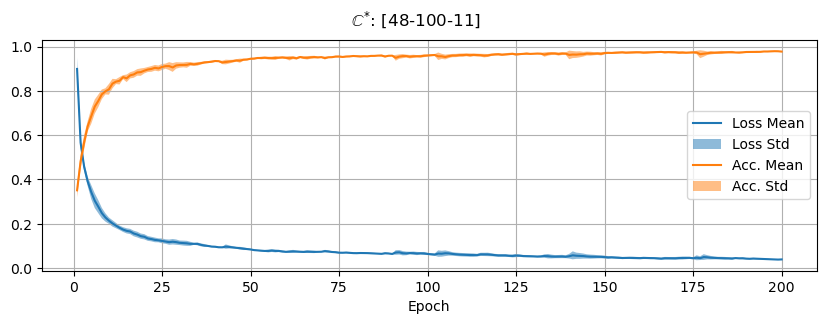

In [ ]:
plot_loss_acc_list(
    "$\mathbb{C}^{*}$: [48-100-11] ",
    list_losses,
    list_scores,
    "mlmvn-mod-48-100-11.png",
)

In [ ]:
task.mark_completed()
task.close()

## Multi Layer

### MLMVN [48-10-10-11]

In [ ]:
PATH = str(Path.cwd() / "models/autass-mlmvn_48-10-10-11.pt")

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 10)
        self.phase_act1 = cmplx_phase_activation()
        self.hidden_layer = HiddenLayer(10, 10)
        self.phase_act2 = cmplx_phase_activation()
        self.linear_out = OutputLayer(10, 11)
        self.phase_act3 = cmplx_phase_activation()
        # Hooks
        self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
            self.first_layer_backward_hook
        )
        self.hidden_layer_hook_handle = self.hidden_layer.register_full_backward_hook(
            self.hidden_layer_backward_hook
        )
        self.output_hook_handle = self.linear_out.register_full_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.hidden_layer(x)
        x = self.phase_act2(x)
        x = self.linear_out(x)
        x = self.phase_act3(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)
    return losses, scores

In [ ]:
task = Task.init(
    project_name="mlmvn",
    task_name="SDD-mlmvn-[48-10-10-11]",
    tags=["mlmvn", "SDD", "multiple_runs", "adjusted_loss_clip_angle_value"],
)
writer = SummaryWriter()

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": 1,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
    "layer": "[48-10-10-11]",
    "loss": "ComplexMSE_adjusted_error",
    "clip_angle_value": clip_angle_value,
}
task.connect(config_dict)

ClearML Task: created new task id=981abbac21de4753879436acdf36c17b
ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/981abbac21de4753879436acdf36c17b/output/log


{'learning_rate': 1,
 'epochs': 200,
 'batch_size': 538,
 'optim': 'ECL',
 'categories': 2,
 'periodicity': 1,
 'layer': '[48-10-10-11]',
 'loss': 'ComplexMSE_adjusted_error',
 'clip_angle_value': 1000000}

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_losses = []
list_scores = []
list_acc = []
list_loss = []
list_f1 = []
list_precision = []
list_recall = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )

    model = Model(categories=categories, periodicity=periodicity)
    criterion = ComplexMSE_adjusted_error.apply
    optimizer = ECL(model.parameters(), lr=lr)

    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    list_scores.append(scores)
    list_losses.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    list_acc.append(acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))
    list_f1.append(
        f1_score(y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0)
    )
    list_precision.append(
        precision_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )
    list_recall.append(
        recall_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )

Logger.current_logger().report_single_value(
    name="val_accuracy_mean",
    value=np.mean(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_accuracy_std",
    value=np.std(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_f1_mean",
    value=np.mean(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_f1_std",
    value=np.std(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_precision_mean",
    value=np.mean(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_precision_std",
    value=np.std(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_recall_mean",
    value=np.mean(list_recall),
)
Logger.current_logger().report_single_value(
    name="val_recall_std",
    value=np.std(list_recall),
)

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



2022-09-28 00:41:30,778 - clearml.frameworks - INFO - Found existing registered model id=410edb2915b24269b7d34f2e38593dff [/home/antonpfeifer/Documents/mlmvn/nbs/examples/autass/models/autass-mlmvn_48-10-10-11.pt] reusing it.
Epoch 9 loss is 0.541454749663616
Epoch 19 loss is 0.8791410713849316
Epoch 29 loss is 0.8839316416940527
Epoch 39 loss is 0.8966399825316692
Epoch 49 loss is 0.9264105355661884
Epoch 59 loss is 0.951371120459427
Epoch 69 loss is 0.9412028121256291
Epoch 79 loss is 0.9732946912045937
Epoch 89 loss is 0.9181100154489218
Epoch 99 loss is 0.9329806316494657
Epoch 109 loss is 0.9328285713006949
Epoch 119 loss is 0.9419897937541761
Epoch 129 loss is 0.9427600691188952
Epoch 139 loss is 0.9091315900275359
Epoch 149 loss is 0.9324776865430842
Epoch 159 loss is 0.9134668719369948
Epoch 169 loss is 0.9403598662976411
Epoch 179 loss is 0.9422566273044115
Epoch 189 loss is 0.9543148096619407
Epoch 199 loss is 0.9549645974775849
Train Acc.:  0.5539342406050377
              p

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.34781102538165637
Epoch 19 loss is 0.4926261439071808
Epoch 29 loss is 0.6328775813367924
Epoch 39 loss is 0.7170839574504813
Epoch 49 loss is 0.6934163739177756
Epoch 59 loss is 0.7141162567964217
Epoch 69 loss is 0.7691114368900678
Epoch 79 loss is 0.7562372003321447
Epoch 89 loss is 0.7766109368260417
Epoch 99 loss is 0.7075230256227628
Epoch 109 loss is 0.7393482060014152
Epoch 119 loss is 0.7458410915657656
Epoch 129 loss is 0.7585006377982786
Epoch 139 loss is 0.7711069196763435
Epoch 149 loss is 0.7341288291259812
Epoch 159 loss is 0.7801133649364619
Epoch 169 loss is 0.7263681341448134
Epoch 179 loss is 0.7519011054649812
Epoch 189 loss is 0.7048160484621695
Epoch 199 loss is 0.7475459901191056
Train Acc.:  0.7177986198645502
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1063
           1       0.83      0.74      0.78      1064
           2       0.94      0.84      0.89      1064
           3       0.

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.608739696487545
Epoch 19 loss is 0.7696193880760408
Epoch 29 loss is 0.803278156062957
Epoch 39 loss is 0.8387883156242925
Epoch 49 loss is 0.7807021280520069
Epoch 59 loss is 0.8088241619223006
Epoch 69 loss is 0.8070463633451938
Epoch 79 loss is 0.7945587323244073
Epoch 89 loss is 0.8392897794392442
Epoch 99 loss is 0.8214029347151293
Epoch 109 loss is 0.8340895850326423
Epoch 119 loss is 0.8219225005001145
Epoch 129 loss is 0.8507321513973675
Epoch 139 loss is 0.8635722140704808
Epoch 149 loss is 0.8446035024910838
Epoch 159 loss is 0.8153800610100258
Epoch 169 loss is 0.860221271499099
Epoch 179 loss is 0.8713979258843838
Epoch 189 loss is 0.8423941483588755
Epoch 199 loss is 0.7982078285674677
Train Acc.:  0.5234687119447946
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1064
           1       0.73      0.59      0.66      1064
           2       0.59      0.22      0.33      1064
           3       0.75  

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.2881004625544315
Epoch 19 loss is 0.257601894880915
Epoch 29 loss is 0.3070432292199646
Epoch 39 loss is 1.0114987272533784
Epoch 49 loss is 1.0626524147227299
Epoch 59 loss is 0.7220235506940849
Epoch 69 loss is 0.8701604350827594
Epoch 79 loss is 1.2108727994663198
Epoch 89 loss is 1.138239338460986
Epoch 99 loss is 1.4603121925675742
Epoch 109 loss is 1.4954496178854135
Epoch 119 loss is 1.2679945725843622
Epoch 129 loss is 1.0164146082349543
Epoch 139 loss is 1.1297298068650685
Epoch 149 loss is 1.253219169435164
Epoch 159 loss is 1.1736291050368979
Epoch 169 loss is 1.1826341111065124
Epoch 179 loss is 1.4031484346107788
Epoch 189 loss is 1.2205340600894026
Epoch 199 loss is 1.3048065655004846
Train Acc.:  0.7068600850300168
              precision    recall  f1-score   support

           0       0.75      0.86      0.80      1063
           1       0.81      0.79      0.80      1064
           2       0.94      0.85      0.89      1064
           3       0.87  

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.5949722022582887
Epoch 19 loss is 0.8542236273844039
Epoch 29 loss is 0.8749541100255886
Epoch 39 loss is 0.9226380212308712
Epoch 49 loss is 0.9189451568276324
Epoch 59 loss is 0.9365599144446709
Epoch 69 loss is 0.9302873031362572
Epoch 79 loss is 0.9133083164488084
Epoch 89 loss is 0.867765838931149
Epoch 99 loss is 0.9202292373715069
Epoch 109 loss is 0.8840360283963321
Epoch 119 loss is 0.8900084272652079
Epoch 129 loss is 0.8624389865444407
Epoch 139 loss is 0.86264759032102
Epoch 149 loss is 0.877634036686458
Epoch 159 loss is 0.8911980209206599
Epoch 169 loss is 0.8815296026365007
Epoch 179 loss is 0.8890566057952398
Epoch 189 loss is 0.8732226294946295
Epoch 199 loss is 0.9232258855476119
Train Acc.:  0.5140470442455188
              precision    recall  f1-score   support

           0       0.80      0.66      0.72      1064
           1       0.72      0.55      0.62      1064
           2       0.75      0.53      0.62      1064
           3       0.75   

In [ ]:
task.mark_completed()
task.close()

### MLMVN [48-20-20-11]

In [ ]:
PATH = str(Path.cwd() / "models/autass-mlmvn_48-20-20-11.pt")

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 20)
        self.phase_act1 = cmplx_phase_activation()
        self.hidden_layer = HiddenLayer(20, 20)
        self.phase_act2 = cmplx_phase_activation()
        self.linear_out = OutputLayer(20, 11)
        self.phase_act3 = cmplx_phase_activation()
        # Hooks
        self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
            self.first_layer_backward_hook
        )
        self.hidden_layer_hook_handle = self.hidden_layer.register_full_backward_hook(
            self.hidden_layer_backward_hook
        )
        self.output_hook_handle = self.linear_out.register_full_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.hidden_layer(x)
        x = self.phase_act2(x)
        x = self.linear_out(x)
        x = self.phase_act3(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)
    return losses, scores

In [ ]:
task = Task.init(
    project_name="mlmvn",
    task_name="SDD-mlmvn-[48-20-20-11]",
    tags=["mlmvn", "SDD", "multiple_runs", "adjusted_loss_clip_angle_value"],
)
writer = SummaryWriter()

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": 1,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
    "layer": "[48-20-20-11]",
    "loss": "ComplexMSE_adjusted_error",
    "clip_angle_value": clip_angle_value,
}
task.connect(config_dict)

ClearML Task: created new task id=21bd2a05ea18403b8c16084955a62c7b
ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/21bd2a05ea18403b8c16084955a62c7b/output/log


{'learning_rate': 1,
 'epochs': 200,
 'batch_size': 538,
 'optim': 'ECL',
 'categories': 2,
 'periodicity': 1,
 'layer': '[48-20-20-11]',
 'loss': 'ComplexMSE_adjusted_error',
 'clip_angle_value': 1000000}

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_losses = []
list_scores = []
list_acc = []
list_loss = []
list_f1 = []
list_precision = []
list_recall = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )

    model = Model(categories=categories, periodicity=periodicity)
    criterion = ComplexMSE_adjusted_error.apply
    optimizer = ECL(model.parameters(), lr=lr)

    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    list_scores.append(scores)
    list_losses.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    list_acc.append(acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))
    list_f1.append(
        f1_score(y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0)
    )
    list_precision.append(
        precision_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )
    list_recall.append(
        recall_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )

Logger.current_logger().report_single_value(
    name="val_accuracy_mean",
    value=np.mean(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_accuracy_std",
    value=np.std(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_f1_mean",
    value=np.mean(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_f1_std",
    value=np.std(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_precision_mean",
    value=np.mean(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_precision_std",
    value=np.std(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_recall_mean",
    value=np.mean(list_recall),
)
Logger.current_logger().report_single_value(
    name="val_recall_std",
    value=np.std(list_recall),
)

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



2022-09-28 01:07:31,491 - clearml.frameworks - INFO - Found existing registered model id=22ba5a4169ed406a9e74f40200bd29a1 [/home/antonpfeifer/Documents/mlmvn/nbs/examples/autass/models/autass-mlmvn_48-20-20-11.pt] reusing it.
Epoch 9 loss is 0.37705022557280987
Epoch 19 loss is 0.2740187803883329
Epoch 29 loss is 0.45516830949325443
Epoch 39 loss is 0.6148356752471408
Epoch 49 loss is 0.6222640142110359
Epoch 59 loss is 0.6982017039915205
Epoch 69 loss is 0.6373358815772685
Epoch 79 loss is 0.6311755328631491
Epoch 89 loss is 0.6082573092923741
Epoch 99 loss is 0.603828268133041
Epoch 109 loss is 0.6389025164997437
Epoch 119 loss is 0.6260305680358405
Epoch 129 loss is 0.6324748094532601
Epoch 139 loss is 0.5943924798856283
Epoch 149 loss is 0.6344508674597645
Epoch 159 loss is 0.6141789833696603
Epoch 169 loss is 0.6086970307893493
Epoch 179 loss is 0.5824319841233837
Epoch 189 loss is 0.6191231138277477
Epoch 199 loss is 0.5666659157355745
Train Acc.:  0.730681308351315
             

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.28806597272279794
Epoch 19 loss is 0.22970233591793254
Epoch 29 loss is 0.28585426998250507
Epoch 39 loss is 0.38502680568849784
Epoch 49 loss is 0.7625332656829702
Epoch 59 loss is 0.6732264557756368
Epoch 69 loss is 0.6217295541960539
Epoch 79 loss is 0.6893322196897432
Epoch 89 loss is 0.6622742723169387
Epoch 99 loss is 0.6960203626199706
Epoch 109 loss is 0.6777245937457624
Epoch 119 loss is 0.7176237176692954
Epoch 129 loss is 0.742547024761961
Epoch 139 loss is 0.7291200957471028
Epoch 149 loss is 0.7470137933371792
Epoch 159 loss is 0.7220883556014549
Epoch 169 loss is 0.7159556336891169
Epoch 179 loss is 0.7108887748361287
Epoch 189 loss is 0.7436282315327294
Epoch 199 loss is 0.694954785146677
Train Acc.:  0.7865276561198111
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1063
           1       0.80      0.74      0.77      1064
           2       0.90      0.76      0.82      1064
           3       0

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.2511134256926335
Epoch 19 loss is 0.22011394441410292
Epoch 29 loss is 0.22056851414206183
Epoch 39 loss is 0.2551644861115903
Epoch 49 loss is 0.47249132940476685
Epoch 59 loss is 0.6799162460754719
Epoch 69 loss is 0.6906088651202789
Epoch 79 loss is 0.7231533868835432
Epoch 89 loss is 0.738398383750411
Epoch 99 loss is 0.7811543296378222
Epoch 109 loss is 0.7535960303277581
Epoch 119 loss is 0.7163676381713118
Epoch 129 loss is 0.7103477423606941
Epoch 139 loss is 0.7078374401246286
Epoch 149 loss is 0.7199227568498184
Epoch 159 loss is 0.7107330170199827
Epoch 169 loss is 0.7056031770853555
Epoch 179 loss is 0.7327502640763232
Epoch 189 loss is 0.7094453790723616
Epoch 199 loss is 0.7120579963814156
Train Acc.:  0.7947956502232572
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      1064
           1       0.85      0.80      0.82      1064
           2       0.87      0.77      0.82      1064
           3       0

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.28920254058590406
Epoch 19 loss is 0.20422793527357072
Epoch 29 loss is 0.23514562707658523
Epoch 39 loss is 0.30951769319469474
Epoch 49 loss is 0.802884197886128
Epoch 59 loss is 0.629426963749978
Epoch 69 loss is 0.6618189152336303
Epoch 79 loss is 0.639523350080704
Epoch 89 loss is 0.6033113390242072
Epoch 99 loss is 0.6365305132984823
Epoch 109 loss is 0.6149712207622507
Epoch 119 loss is 0.6332012921437696
Epoch 129 loss is 0.6520249413523534
Epoch 139 loss is 0.6450135768078111
Epoch 149 loss is 0.6724773114718959
Epoch 159 loss is 0.637959073743463
Epoch 169 loss is 0.5887977689032348
Epoch 179 loss is 0.6275123627575196
Epoch 189 loss is 0.6157577124370395
Epoch 199 loss is 0.5571599018372312
Train Acc.:  0.7962056957292712
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1063
           1       0.84      0.81      0.83      1064
           2       0.93      0.86      0.90      1064
           3       0.8

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.3162340976591865
Epoch 19 loss is 0.23035400757661567
Epoch 29 loss is 0.3025872000844228
Epoch 39 loss is 0.5825874736764202
Epoch 49 loss is 0.5903150798951642
Epoch 59 loss is 0.5290111967616761
Epoch 69 loss is 0.48948755510049063
Epoch 79 loss is 0.5536584861929144
Epoch 89 loss is 0.5714292967837328
Epoch 99 loss is 0.6023988021147385
Epoch 109 loss is 0.6004173386515079
Epoch 119 loss is 0.5901975806362378
Epoch 129 loss is 0.607343459187801
Epoch 139 loss is 0.6290455412143036
Epoch 149 loss is 0.598815193614319
Epoch 159 loss is 0.5928518543280813
Epoch 169 loss is 0.6891633674581874
Epoch 179 loss is 0.6508888532882792
Epoch 189 loss is 0.6662645081833795
Epoch 199 loss is 0.6955834762648595
Train Acc.:  0.7916550943234987
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1064
           1       0.78      0.69      0.73      1064
           2       0.89      0.81      0.85      1064
           3       0.9

In [ ]:
task.mark_completed()
task.close()

### MLMVN [48-50-50-11]

In [ ]:
PATH = str(Path.cwd() / "models/autass-mlmvn_48-50-50-11.pt")

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 50)
        self.phase_act1 = cmplx_phase_activation()
        self.hidden_layer = HiddenLayer(50, 50)
        self.phase_act2 = cmplx_phase_activation()
        self.linear_out = OutputLayer(50, 11)
        self.phase_act3 = cmplx_phase_activation()
        # Hooks
        self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
            self.first_layer_backward_hook
        )
        self.hidden_layer_hook_handle = self.hidden_layer.register_full_backward_hook(
            self.hidden_layer_backward_hook
        )
        self.output_hook_handle = self.linear_out.register_full_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.hidden_layer(x)
        x = self.phase_act2(x)
        x = self.linear_out(x)
        x = self.phase_act3(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)
    return losses, scores

In [ ]:
task = Task.init(
    project_name="mlmvn",
    task_name="SDD-mlmvn-[48-50-50-11]",
    tags=["mlmvn", "SDD", "multiple_runs", "adjusted_loss_clip_angle_value"],
)
writer = SummaryWriter()

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": 1,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
    "layer": "[48-50-50-11]",
    "loss": "ComplexMSE_adjusted_error",
    "clip_angle_value": clip_angle_value,
}
task.connect(config_dict)

ClearML Task: created new task id=fad0aa6b39774a1a941093cdfe9dbafe
ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/fad0aa6b39774a1a941093cdfe9dbafe/output/log


{'learning_rate': 1,
 'epochs': 200,
 'batch_size': 538,
 'optim': 'ECL',
 'categories': 2,
 'periodicity': 1,
 'layer': '[48-50-50-11]',
 'loss': 'ComplexMSE_adjusted_error',
 'clip_angle_value': 1000000}

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_losses = []
list_scores = []
list_acc = []
list_loss = []
list_f1 = []
list_precision = []
list_recall = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )

    model = Model(categories=categories, periodicity=periodicity)
    criterion = ComplexMSE_adjusted_error.apply
    optimizer = ECL(model.parameters(), lr=lr)

    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    list_scores.append(scores)
    list_losses.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    list_acc.append(acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))
    list_f1.append(
        f1_score(y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0)
    )
    list_precision.append(
        precision_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )
    list_recall.append(
        recall_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )

Logger.current_logger().report_single_value(
    name="val_accuracy_mean",
    value=np.mean(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_accuracy_std",
    value=np.std(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_f1_mean",
    value=np.mean(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_f1_std",
    value=np.std(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_precision_mean",
    value=np.mean(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_precision_std",
    value=np.std(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_recall_mean",
    value=np.mean(list_recall),
)
Logger.current_logger().report_single_value(
    name="val_recall_std",
    value=np.std(list_recall),
)

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



2022-09-28 01:32:30,550 - clearml.frameworks - INFO - Found existing registered model id=f13061c5d03a4e96b788becd5e54443a [/home/antonpfeifer/Documents/mlmvn/nbs/examples/autass/models/autass-mlmvn_48-50-50-11.pt] reusing it.
Epoch 9 loss is 0.28872390806294274
Epoch 19 loss is 0.17694585572096805
Epoch 29 loss is 0.1425961563405807
Epoch 39 loss is 0.12819857234772986
Epoch 49 loss is 0.127805551287352
Epoch 59 loss is 0.11392432030870624
Epoch 69 loss is 0.09727040211071439
Epoch 79 loss is 0.09686726724688864
Epoch 89 loss is 0.09030257402693799
Epoch 99 loss is 0.09027066309985042
Epoch 109 loss is 0.08883324592656906
Epoch 119 loss is 0.08907481171375083
Epoch 129 loss is 0.08302457843559832
Epoch 139 loss is 0.07895430465486417
Epoch 149 loss is 0.07612614811554756
Epoch 159 loss is 0.0712898657302396
Epoch 169 loss is 0.08380639698034706
Epoch 179 loss is 0.07950043128200916
Epoch 189 loss is 0.08736764655981065
Epoch 199 loss is 0.09124728414202767
Train Acc.:  0.94111991796098

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.2861673749427943
Epoch 19 loss is 0.2201654650800628
Epoch 29 loss is 0.1594589809702913
Epoch 39 loss is 0.13540895566103234
Epoch 49 loss is 0.11925421445742292
Epoch 59 loss is 0.11962160650088925
Epoch 69 loss is 0.11841529734011198
Epoch 79 loss is 0.1179027595753925
Epoch 89 loss is 0.1180392008192653
Epoch 99 loss is 0.11441886133599923
Epoch 109 loss is 0.10782047828315887
Epoch 119 loss is 0.10705718301534183
Epoch 129 loss is 0.10427072867703205
Epoch 139 loss is 0.10474216368094652
Epoch 149 loss is 0.10551091888301718
Epoch 159 loss is 0.10684330984217699
Epoch 169 loss is 0.09317834493277641
Epoch 179 loss is 0.0892558164282839
Epoch 189 loss is 0.08739703451707423
Epoch 199 loss is 0.09199028421820245
Train Acc.:  0.9275749353729144
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1063
           1       0.92      0.88      0.90      1064
           2       0.98      0.98      0.98      1064
        

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.27623336473650534
Epoch 19 loss is 0.16289381252737087
Epoch 29 loss is 0.14757027886946592
Epoch 39 loss is 0.1330734318315473
Epoch 49 loss is 0.11679790998549922
Epoch 59 loss is 0.11167467752516336
Epoch 69 loss is 0.11268039833791481
Epoch 79 loss is 0.10041605954925376
Epoch 89 loss is 0.10264455966541974
Epoch 99 loss is 0.10157209891611255
Epoch 109 loss is 0.09768154280892237
Epoch 119 loss is 0.09983357506318141
Epoch 129 loss is 0.09887546788082555
Epoch 139 loss is 0.0888411840117014
Epoch 149 loss is 0.10038184391363476
Epoch 159 loss is 0.08949124574344279
Epoch 169 loss is 0.09784304006405145
Epoch 179 loss is 0.09877557601509657
Epoch 189 loss is 0.10217435454327402
Epoch 199 loss is 0.1057261382783362
Train Acc.:  0.9322750870596278
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1064
           1       0.91      0.91      0.91      1064
           2       0.98      0.96      0.97      1064
     

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.28693840838047774
Epoch 19 loss is 0.20104936966743658
Epoch 29 loss is 0.15755177961335037
Epoch 39 loss is 0.1288596346987444
Epoch 49 loss is 0.12720331433512763
Epoch 59 loss is 0.12023218874962663
Epoch 69 loss is 0.11721781830240018
Epoch 79 loss is 0.10656089263296499
Epoch 89 loss is 0.09562316810246828
Epoch 99 loss is 0.09102231637919944
Epoch 109 loss is 0.09233467007446912
Epoch 119 loss is 0.09115643363442122
Epoch 129 loss is 0.08620270800916764
Epoch 139 loss is 0.11083394580512573
Epoch 149 loss is 0.10150878655964381
Epoch 159 loss is 0.10271093352938551
Epoch 169 loss is 0.10444855459263125
Epoch 179 loss is 0.09594796640621853
Epoch 189 loss is 0.09849182497560287
Epoch 199 loss is 0.1036780848914241
Train Acc.:  0.924904394641827
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1063
           1       0.91      0.88      0.89      1064
           2       0.98      0.96      0.97      1064
     

/tmp/ipykernel_13327/161459083.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.3034027193057795
Epoch 19 loss is 0.17692890093552524
Epoch 29 loss is 0.13786514238212272
Epoch 39 loss is 0.12331394422598127
Epoch 49 loss is 0.1237987767889628
Epoch 59 loss is 0.11048595570606672
Epoch 69 loss is 0.09570147391418123
Epoch 79 loss is 0.09912258426639196
Epoch 89 loss is 0.09599648621108799
Epoch 99 loss is 0.0873050642910436
Epoch 109 loss is 0.10142020273437256
Epoch 119 loss is 0.1003337232560557
Epoch 129 loss is 0.10045847144167147
Epoch 139 loss is 0.09709811021654463
Epoch 149 loss is 0.0970311573500608
Epoch 159 loss is 0.09226866990186595
Epoch 169 loss is 0.08758580671534028
Epoch 179 loss is 0.08792805539701785
Epoch 189 loss is 0.08792941901672958
Epoch 199 loss is 0.09815684767604878
Train Acc.:  0.9300959258230607
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1064
           1       0.91      0.90      0.91      1064
           2       0.98      0.97      0.97      1064
       

In [ ]:
task.mark_completed()
task.close()

### MLMVN [48-100-100-11]

In [ ]:
PATH = str(Path.cwd() / "models/autass-mlmvn_48-100-100-11.pt")

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 100)
        self.phase_act1 = cmplx_phase_activation()
        self.hidden_layer = HiddenLayer(100, 100)
        self.phase_act2 = cmplx_phase_activation()
        self.linear_out = OutputLayer(100, 11)
        self.phase_act3 = cmplx_phase_activation()
        # Hooks
        self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
            self.first_layer_backward_hook
        )
        self.hidden_layer_hook_handle = self.hidden_layer.register_full_backward_hook(
            self.hidden_layer_backward_hook
        )
        self.output_hook_handle = self.linear_out.register_full_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.hidden_layer(x)
        x = self.phase_act2(x)
        x = self.linear_out(x)
        x = self.phase_act3(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)
    return losses, scores

In [ ]:
task = Task.init(
    project_name="mlmvn",
    task_name="SDD-mlmvn-[48-100-100-11]",
    tags=["mlmvn", "SDD", "multiple_runs", "adjusted_loss_clip_angle_value"],
)
writer = SummaryWriter()

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": lr,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
    "layer": "[48-100-100-11]",
    "loss": "ComplexMSE_adjusted_error",
    "clip_angle_value": clip_angle_value,
}
task.connect(config_dict)

ClearML Task: created new task id=2153a3d90993455089c1f2cf7305bb59
ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/2153a3d90993455089c1f2cf7305bb59/output/log


{'learning_rate': 1,
 'epochs': 200,
 'batch_size': 538,
 'optim': 'ECL',
 'categories': 2,
 'periodicity': 1,
 'layer': '[48-100-100-11]',
 'loss': 'ComplexMSE_adjusted_error',
 'clip_angle_value': 1000000}

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_losses = []
list_scores = []
list_acc = []
list_loss = []
list_f1 = []
list_precision = []
list_recall = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )

    model = Model(categories=categories, periodicity=periodicity)
    criterion = ComplexMSE_adjusted_error.apply
    optimizer = ECL(model.parameters(), lr=lr)

    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    list_scores.append(scores)
    list_losses.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    list_acc.append(acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))
    list_f1.append(
        f1_score(y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0)
    )
    list_precision.append(
        precision_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )
    list_recall.append(
        recall_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )

Logger.current_logger().report_single_value(
    name="val_accuracy_mean",
    value=np.mean(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_accuracy_std",
    value=np.std(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_f1_mean",
    value=np.mean(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_f1_std",
    value=np.std(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_precision_mean",
    value=np.mean(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_precision_std",
    value=np.std(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_recall_mean",
    value=np.mean(list_recall),
)
Logger.current_logger().report_single_value(
    name="val_recall_std",
    value=np.std(list_recall),
)

/tmp/ipykernel_2379/74840955.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



2022-09-29 14:17:44,211 - clearml.frameworks - INFO - Found existing registered model id=bbd65d869dea4025af46d264d3c7bdee [/home/antonpfeifer/Documents/mlmvn/nbs/examples/autass/models/autass-mlmvn_48-100-100-11.pt] reusing it.
Epoch 9 loss is 0.38493101436237465
Epoch 19 loss is 0.1983475963903122
Epoch 29 loss is 0.15240658259145864
Epoch 39 loss is 0.12849809119734149
Epoch 49 loss is 0.11291338514495056
Epoch 59 loss is 0.10350603182093213
Epoch 69 loss is 0.09896006818913682
Epoch 79 loss is 0.09073580641413742
Epoch 89 loss is 0.08624265189956253
Epoch 99 loss is 0.07990884906610474
Epoch 109 loss is 0.07774202154480073
Epoch 119 loss is 0.0778207451859103
Epoch 129 loss is 0.07292320971236593
Epoch 139 loss is 0.08220096647261978
Epoch 149 loss is 0.07259278084390995
Epoch 159 loss is 0.07333743296400583
Epoch 169 loss is 0.06768991486550634
Epoch 179 loss is 0.06486413256485078
Epoch 189 loss is 0.0663716789708822
Epoch 199 loss is 0.06601747100440022
Train Acc.:  0.95515628004

ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/2153a3d90993455089c1f2cf7305bb59/output/log
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


/tmp/ipykernel_2379/74840955.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.4015647773116825
Epoch 19 loss is 0.21324193953061343
Epoch 29 loss is 0.16244134629623966
Epoch 39 loss is 0.13968662879021496
Epoch 49 loss is 0.1220346592068794
Epoch 59 loss is 0.11857350072574051
Epoch 69 loss is 0.10683356304935711
Epoch 79 loss is 0.09876512760527531
Epoch 89 loss is 0.10028214707730271
Epoch 99 loss is 0.09386611501220359
Epoch 109 loss is 0.09131180958378789
Epoch 119 loss is 0.08078602213530815
Epoch 129 loss is 0.07812674516622654
Epoch 139 loss is 0.07368491314841398
Epoch 149 loss is 0.07233171681695082
Epoch 159 loss is 0.07153585909897314
Epoch 169 loss is 0.07045204344853243
Epoch 179 loss is 0.07031483192734578
Epoch 189 loss is 0.06762652182875349
Epoch 199 loss is 0.06935222633418742
Train Acc.:  0.9489606255474609
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1063
           1       0.94      0.90      0.92      1064
           2       0.98      0.97      0.97      1064
    

/tmp/ipykernel_2379/74840955.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.35830112541567166
Epoch 19 loss is 0.20503370425712947
Epoch 29 loss is 0.1615004405052233
Epoch 39 loss is 0.14478501770353844
Epoch 49 loss is 0.13139543735043546
Epoch 59 loss is 0.12132454251093122
Epoch 69 loss is 0.11744575716216751
Epoch 79 loss is 0.11623840924937114
Epoch 89 loss is 0.11783017747510419
Epoch 99 loss is 0.11593023945022461
Epoch 109 loss is 0.11583587087231882
Epoch 119 loss is 0.11662312303478367
Epoch 129 loss is 0.11691969687131881
Epoch 139 loss is 0.10854572296958728
Epoch 149 loss is 0.10796596240824434
Epoch 159 loss is 0.11262345830304454
Epoch 169 loss is 0.10184479776708627
Epoch 179 loss is 0.09605088202087457
Epoch 189 loss is 0.09299509987805853
Epoch 199 loss is 0.08898415836437445
Train Acc.:  0.9210374516632127
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1064
           1       0.91      0.89      0.90      1064
           2       0.98      0.95      0.97      1064
   

/tmp/ipykernel_2379/74840955.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.3732331507452995
Epoch 19 loss is 0.2151142782886408
Epoch 29 loss is 0.1693622907950432
Epoch 39 loss is 0.14709019657419897
Epoch 49 loss is 0.13360652890401162
Epoch 59 loss is 0.12738859159159088
Epoch 69 loss is 0.11634673967810212
Epoch 79 loss is 0.10559853905524143
Epoch 89 loss is 0.10185721106569144
Epoch 99 loss is 0.10076346263612189
Epoch 109 loss is 0.0951012106512096
Epoch 119 loss is 0.0863301443776767
Epoch 129 loss is 0.08374395534767522
Epoch 139 loss is 0.08192660695129174
Epoch 149 loss is 0.0808713694226275
Epoch 159 loss is 0.08485596063007796
Epoch 169 loss is 0.07577642509867422
Epoch 179 loss is 0.07399703079870644
Epoch 189 loss is 0.07316694645295278
Epoch 199 loss is 0.07004600393121947
Train Acc.:  0.9438972803213195
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1063
           1       0.93      0.91      0.92      1064
           2       0.98      0.96      0.97      1064
        

/tmp/ipykernel_2379/74840955.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.3860148494765397
Epoch 19 loss is 0.20866529165214284
Epoch 29 loss is 0.16247025892118347
Epoch 39 loss is 0.13564982800723918
Epoch 49 loss is 0.1240512973257284
Epoch 59 loss is 0.113934101224775
Epoch 69 loss is 0.11061596169703837
Epoch 79 loss is 0.10461476570112285
Epoch 89 loss is 0.10298748909019034
Epoch 99 loss is 0.09786684313663066
Epoch 109 loss is 0.0988537740332937
Epoch 119 loss is 0.09090053269267047
Epoch 129 loss is 0.08742530763329877
Epoch 139 loss is 0.0841747421040788
Epoch 149 loss is 0.08610848018045644
Epoch 159 loss is 0.07819941018533352
Epoch 169 loss is 0.07596165720615952
Epoch 179 loss is 0.07426260096075489
Epoch 189 loss is 0.07633927124679218
Epoch 199 loss is 0.07405352525764859
Train Acc.:  0.9421454056017262
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1064
           1       0.91      0.90      0.91      1064
           2       0.97      0.96      0.96      1064
        

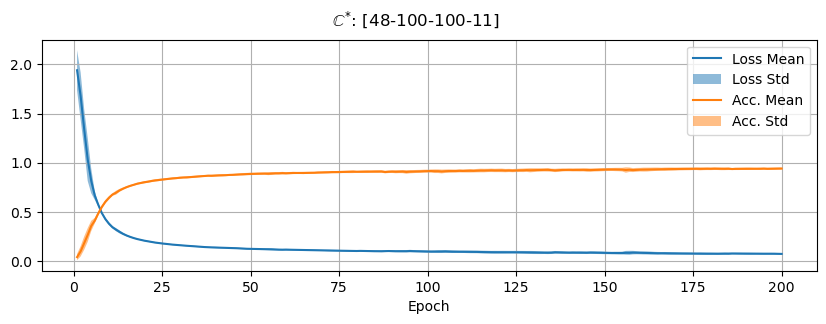

In [ ]:
plot_loss_acc_list(
    "$\mathbb{C}^{*}$: [48-100-100-11] ",
    list_losses,
    list_scores,
    "mlmvn-mod-48-100-100-11.png",
)

In [ ]:
task.mark_completed()
task.close()